In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.lines as mlines

from sklearn import datasets
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, \
    average_precision_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import accuracy_score

import theano
import theano.tensor as T

from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense#, Dropout, BatchNormalization, TimeDistributed, LSTM
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam

Using cuDNN version 5110 on context None
Mapped name None to device cuda0: TITAN X (Pascal) (0000:22:00.0)
Using Theano backend.


## Make data

In [179]:
class Data:
    def __init__(self, nrows=1500, n_feats=2, n_labels = 2, seed='set'):
        self.nrows = nrows
        self.n_feats = n_feats
        self.n_labels = n_labels
        self.n_seed = seed
        
    def generate(self):   
        if self.n_seed == 'set':
            np.random.seed(1980)
        self.X = np.random.normal(size=(self.nrows, self.n_feats))
        self.X_aug = np.hstack((np.ones((self.nrows,1)), self.X))
        self.W = np.random.randint(1, high=9, size=(self.n_labels, self.n_feats+1))
        self.Z = np.dot(self.X_aug, self.W.T)
        self.pr = self._softmax(self.Z)
        self.Y = np.vstack([np.random.multinomial(1, self.pr[i,:], size=1) \
                            for i in range(self.nrows)] )
        self.y = self._make_y(self.Y).ravel()    
            
    def _softmax(self, X):
        row_maxs = np.max(X, axis=1).reshape(-1,1)
        e_x = np.exp(X - row_maxs)
        row_sums = e_x.sum(axis=1).reshape(-1,1) 
        return e_x / row_sums
    
    def _make_y(self, Y):    
        y = np.zeros((Y.shape[0],1))    
        for j in range(Y.shape[1]):
            is_one = Y[:,j]==1
            y[is_one,:] = j
        return y

## Make binary data

In [127]:
d = Data(n_labels=2)
d.generate()

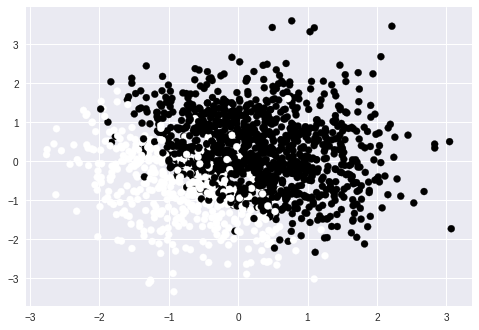

In [128]:
h = plt.scatter(d.X[:,0], d.X[:,1], s=None, c=d.y);

In [129]:
d.W

array([[1, 4, 2],
       [4, 8, 5]])

In [77]:
dwp = d.W[1,:] - d.W[0,:]
dwp

array([3, 4, 3])

In [80]:
print 'in ax+b, a=', dwp[1]/(-dwp[2]).astype(float), 'b=', dwp[0]/(-dwp[2]).astype(float)

in ax+b, a= -1.33333333333 b= -1.0


## SKLearn

In [44]:
lr = LogisticRegression(max_iter=1000, C = 1e6)

In [45]:
lr.fit(d.X, d.y)

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [46]:
np.hstack((lr.intercept_.reshape(-1,1), lr.coef_))

array([[ 2.89142029,  3.73571406,  2.94121269]])

In [47]:
a = lr.coef_[0,0]/float(-lr.coef_[0,1])
b = lr.intercept_[0]/float(-lr.coef_[0,1] )
print 'in y=ax+b'
print 'a =', a
print 'b =', b

in y=ax+b
a = -1.27012714124
b = -0.98307079474


In [34]:
trues = ((y_pred>0.5) & (d.y == 1)) | ((y_pred<0.5) & (d.y == 0))
f1 = ((y_pred<0.5) & (d.y == 1)) 
f2 = ((y_pred>0.5) & (d.y == 0))

In [41]:
xmin, xmax = h.axes.get_xlim()
xinterp = np.linspace(xmin, xmax, 50)

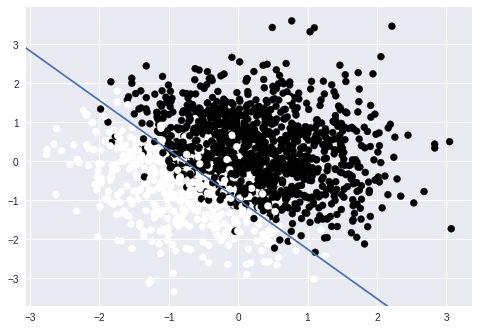

In [48]:
h = plt.scatter(d.X[:,0], d.X[:,1], s=None, c=d.y);
ylims = h.axes.get_ylim()
xlims = h.axes.get_xlim();
plt.plot(xinterp, a*xinterp+b);
plt.xlim(xlims);
plt.ylim(ylims);

In [50]:
y_pred = lr.predict(d.X)

In [51]:
accuracy_score(y_pred=y_pred, y_true=d.y)

0.90333333333333332

In [52]:
def ROC(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Calculate Precision-Recall curve
    prec, rec, _ = precision_recall_curve(y_test, y_pred)
    avg_prec = average_precision_score(y_test, y_pred)

    # Plot
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(plt.gcf().get_size_inches() * np.array([2, 1]))
    ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax[0].plot([0, 1], [0, 1], 'k--')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC curve')
    ax[0].legend(loc="lower right")
    plt.plot(rec, prec, label='Precision-Recall curve (area = %0.3f)' % avg_prec)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="upper right")

    plt.show()

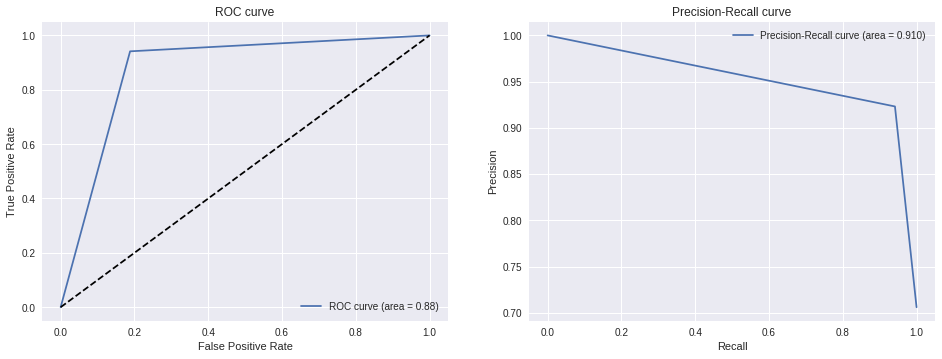

In [53]:
ROC(d.y, y_pred) 

## Theano 

In [54]:
def make_theano_model(X, y, training_steps=10000, lamdba=0, lr=0.5):    
    N = len(y)
    feats = X.shape[1]
    D = (X, y)
    
    
    # Declare Theano symbolic variables
    x = T.dmatrix("x")
    y = T.dvector("y")

    # initialize the weight vector w randomly
    #
    # this and the following bias variable b
    # are shared so they keep their values
    # between training iterations (updates)
    w = theano.shared(np.random.randn(feats), name="w")

    # initialize the bias term
    b = theano.shared(0., name="b")

    # Construct Theano expression graph
    p_1 = 1 / (1 + T.exp(-T.dot(x, w) - b))   # Probability that target = 1
    prediction = p_1 > 0.5                    # The prediction thresholded
    xent = -y * T.log(p_1) - (1-y) * T.log(1-p_1) # Cross-entropy loss function
    cost = xent.mean() + lamdba * (w ** 2).sum()# The cost to minimize
    gw, gb = T.grad(cost, [w, b])             # Compute the gradient of the cost
                                              # w.r.t weight vector w and
                                              # bias term b
                                              # (we shall return to this in a
                                              # following section of this tutorial)

    # Compile
    train = theano.function(
              inputs=[x,y],
              outputs=[prediction, xent],
              updates=((w, w - lr * gw), (b, b - lr * gb)))
    predict = theano.function(inputs=[x], outputs=prediction)

    # Train
    for i in tqdm(range(training_steps)):
        pred, err = train(D[0], D[1])

    return w, b, predict

In [55]:
[w, b, predict] = make_theano_model(d.X, d.y)

100%|██████████| 10000/10000 [00:02<00:00, 3512.13it/s]


In [56]:
print("Coefficients:")
print np.hstack( ( b.get_value().reshape(-1), w.get_value() ) )

Coefficients:
[ 2.89190864  3.73633205  2.94177421]


In [57]:
print 'in y=ax+b'
print 'a =', w.get_value()[0]/float(-w.get_value()[1])
print 'b =', b.get_value()/float(-w.get_value()[1] )

in y=ax+b
a = -1.27009477355
b = -0.983049150141


## Keras

In [81]:
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=d.X.shape[1]))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
h = model.fit(d.X, d.y, epochs=100)

Epoch 1/100
1500/1500 [==============================] - 0s - loss: 0.5901 - acc: 0.6720     
Epoch 2/100
1500/1500 [==============================] - 0s - loss: 0.5694 - acc: 0.6913     
Epoch 3/100
1500/1500 [==============================] - 0s - loss: 0.5505 - acc: 0.7040     
Epoch 4/100
1500/1500 [==============================] - 0s - loss: 0.5322 - acc: 0.7200     
Epoch 5/100
1500/1500 [==============================] - 0s - loss: 0.5156 - acc: 0.7367     
Epoch 6/100
1500/1500 [==============================] - 0s - loss: 0.4991 - acc: 0.7507     
Epoch 7/100
1500/1500 [==============================] - 0s - loss: 0.4838 - acc: 0.7673     
Epoch 8/100
1500/1500 [==============================] - 0s - loss: 0.4692 - acc: 0.7813     
Epoch 9/100
1500/1500 [==============================] - 0s - loss: 0.4555 - acc: 0.7980     
Epoch 10/100
1500/1500 [==============================] - 0s - loss: 0.4427 - acc: 0.8067     
Epoch 11/100
1500/1500 [==============================] - 0

1500/1500 [==============================] - 0s - loss: 0.2341 - acc: 0.9027     
Epoch 88/100
1500/1500 [==============================] - 0s - loss: 0.2338 - acc: 0.9033     
Epoch 89/100
1500/1500 [==============================] - 0s - loss: 0.2336 - acc: 0.9027     
Epoch 90/100
1500/1500 [==============================] - 0s - loss: 0.2333 - acc: 0.9020     
Epoch 91/100
1500/1500 [==============================] - 0s - loss: 0.2331 - acc: 0.9027     
Epoch 92/100
1500/1500 [==============================] - 0s - loss: 0.2328 - acc: 0.9033     
Epoch 93/100
1500/1500 [==============================] - 0s - loss: 0.2326 - acc: 0.9020     
Epoch 94/100
1500/1500 [==============================] - 0s - loss: 0.2324 - acc: 0.9033     
Epoch 95/100
1500/1500 [==============================] - 0s - loss: 0.2322 - acc: 0.9027     
Epoch 96/100
1500/1500 [==============================] - 0s - loss: 0.2320 - acc: 0.9033     
Epoch 97/100
1500/1500 [==============================] - 0s - 

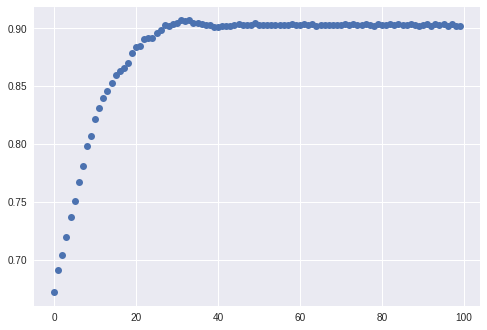

In [82]:
  plt.plot(h.history['acc'],'o') 

In [83]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arra
biases = weights[1].reshape(1,-1)
weights = weights[0].reshape(1,-1)

In [84]:
weights

array([[ 2.8006351 ,  2.18383169]], dtype=float32)

In [85]:
biases

array([[ 2.16710687]], dtype=float32)

In [97]:
np.hstack([biases, weights])

array([[ 2.16710687,  2.8006351 ,  2.18383169]], dtype=float32)

In [94]:
factor = np.hstack( ( b.get_value().reshape(-1), w.get_value() ) )/np.hstack([biases, weights])
factor

array([[ 1.33445594,  1.3341017 ,  1.34707002]])

In [98]:
np.hstack([biases, weights])*1.33

array([[ 2.88225222,  3.72484469,  2.90449619]], dtype=float32)

In [87]:
print 'in y=ax+b'
print 'a =', weights[0,0]/(-weights[0,1])
print 'b =', biases[0,0]/(-weights[0,1])

in y=ax+b
a = -1.28244
b = -0.992342


## Pure python

In [99]:
def pp_log_reg(X, y, n_epochs = 25, learning_rate = 50, lambda_=0):
    n_rows, n_feats = X.shape
    w = np.random.rand(n_feats+1, 1) #initialize w
    X = np.hstack((np.ones((n_rows, 1)), X)) #augment X
    Lambda = np.ones((n_feats+1,1))*lambda_
    Lambda[0] = 0
    for _ in range(n_epochs):        
        for xi, yi in zip(X,y):
            xi = xi.reshape(-1,1)
            zi = np.dot(w.T, xi)
            pi = 1/(1 + np.exp(-zi))
            dJdw = 1/float(n_rows)*( (pi - yi)*xi + Lambda*w ) 
            w = w - learning_rate*dJdw
    return w

In [100]:
w = pp_log_reg(d.X, d.y)
w

array([[ 2.75993703],
       [ 3.80464519],
       [ 2.95430781]])

## Pure python batch GD

In [105]:
def pp_lr_bgd(X, y, batch_size = 500, n_epochs = 2000, learning_rate = 5, lambda_ = 0):
    n_rows, n_feats = X.shape
    w = np.random.rand(n_feats+1, 1) #initialize w
    X = np.hstack((np.ones((n_rows, 1)), X)) #augment X
    n_batches = n_rows/batch_size
    Lambda = np.diag(np.ones((n_feats+1,)))*lambda_
    Lambda[0,0] = 0

    for _ in range(n_epochs):
        for i in range(n_batches):
            lb, ub = i*batch_size, (i+1)*batch_size-1
            X_batch = X[lb:ub, :]
            y_batch = y[lb:ub]
            Z = np.dot(X_batch, w)
            h = 1/(1 + np.exp(-Z))
            dJdw = 1/float(batch_size)\
                    *(np.dot(np.transpose(X_batch), h - y_batch.reshape(-1,1) ) + np.dot(Lambda, w ))
            w = w - learning_rate*dJdw
    return w



In [106]:
w = pp_lr_bgd(d.X, d.y)
w

array([[ 2.86510392],
       [ 3.76987171],
       [ 2.95194959]])

## Multinomial LR

In [180]:
dd = Data(n_feats=5, n_labels=3)
dd.generate()

## SKLearn

In [193]:
sklearn_lr = LogisticRegression(max_iter=1000, C = 1e6)

In [194]:
lr.fit(dd.X, dd.y)

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [195]:
np.hstack((lr.intercept_.reshape(-1,1), lr.coef_))

array([[-3.15658622,  1.60178915, -1.30107314, -1.34847075, -1.42618212,
        -3.11060128],
       [ 1.02492416, -3.51320571, -0.21453131, -1.55648735,  3.69591732,
         4.03644283],
       [-4.20219785,  1.64067447,  1.75247033,  3.09915196, -2.00621937,
        -0.2104194 ]])

In [196]:
lr.coef_

array([[ 1.60178915, -1.30107314, -1.34847075, -1.42618212, -3.11060128],
       [-3.51320571, -0.21453131, -1.55648735,  3.69591732,  4.03644283],
       [ 1.64067447,  1.75247033,  3.09915196, -2.00621937, -0.2104194 ]])

In [197]:
lr.intercept_

array([-3.15658622,  1.02492416, -4.20219785])

## Manual Implementations

### Pure Python OVR

In [201]:
def pp_multi_log_reg(X, y, n_epochs = 500, learning_rate = 1, lambda_=0):
    n_rows, n_feats = X.shape
    n_labels = len(np.unique(y))
    
    all_w = np.random.rand(n_labels, n_feats+1) #initialize w
    X = np.hstack((np.ones((n_rows, 1)), X)) #augment X
    Lambda = np.ones((n_feats+1,1))*lambda_
    Lambda[0] = 0
    
    for n_labl in range(n_labels):
        wj = all_w[n_labl, :]
        wj = wj.reshape(-1,1)
        for _ in range(n_epochs):        
            for xi, yi in zip(X,y==n_labl):
                xi = xi.reshape(-1,1)
                yi = yi.reshape(-1, 1)
                zi = np.dot(wj.T, xi)
                pi = 1/(1 + np.exp(-zi))
                dJdw = 1/float(n_rows)*( (pi - yi)*xi )#+ Lambda*w ) 
                wj = wj - learning_rate*dJdw
        all_w[n_labl,:] = wj.reshape(1,-1)
    return all_w

In [202]:
w = pp_multi_log_reg(dd.X, dd.y)

In [203]:
w[:,1:]

array([[ 1.58986672, -1.28877073, -1.33778322, -1.41468353, -3.08250346],
       [-3.3358047 , -0.20067089, -1.47562572,  3.5084136 ,  3.82808418],
       [ 1.5905105 ,  1.69923741,  3.00580383, -1.94455313, -0.20405958]])

In [204]:
lr.coef_

array([[ 1.60178915, -1.30107314, -1.34847075, -1.42618212, -3.11060128],
       [-3.51320571, -0.21453131, -1.55648735,  3.69591732,  4.03644283],
       [ 1.64067447,  1.75247033,  3.09915196, -2.00621937, -0.2104194 ]])

In [205]:
w[:,0]

array([-3.12913288,  0.97481063, -4.07746144])

In [206]:
lr.intercept_

array([-3.15658622,  1.02492416, -4.20219785])

### Pure Python Batch GD OVR

In [208]:
def pp_multi_lr_bgd(X, y, batch_size = 500, n_epochs = 500, learning_rate = 0.5, lambda_ = 0):
    n_rows, n_feats = X.shape
    n_labels = len(np.unique(y))
#     print 'n labels:', n_labels
    all_w = np.random.rand(n_labels, n_feats+1) #initialize w
    X = np.hstack((np.ones((n_rows, 1)), X)) #augment X
    n_batches = max([n_rows/batch_size,1])
#     print 'n_batches:', n_batches
    Lambda = np.diag(np.ones((n_feats+1,)))*lambda_
    Lambda[0,0] = 0
    for n_labl in range(n_labels):
        yj = y==n_labl
        wj = all_w[n_labl, :]
        wj = wj.reshape(-1,1)
#         print 'wj shape: ', wj.shape
        for _ in range(n_epochs):
            for i in range(n_batches):
                lb, ub = i*batch_size, (i+1)*batch_size-1
#                 print 'lb:', lb, 'ub:', ub
                X_batch = X[lb:ub, :]
                y_batch = yj[lb:ub].reshape(-1,1)
#                 print 'X_batch.shape: ', X_batch.shape
#                 print 't_batch.shape: ', y_batch.shape                
                Z = np.dot(X_batch, wj)
#                 print 'Z.shape',Z.shape
                h = 1/(1 + np.exp(-Z))
                dJdw = 1/float(batch_size)\
                        *(np.dot(np.transpose(X_batch), h - y_batch ) + np.dot(Lambda, wj ))
#                 print 'dJdw.shape:',dJdw.shape    
                wj = wj - learning_rate*dJdw
        all_w[n_labl,:] = wj.reshape(1,-1)
    return all_w

In [210]:
w = pp_multi_lr_bgd(dd.X, dd.y)

In [211]:
w[:,1:]

array([[ 1.59832713, -1.30453205, -1.35148389, -1.42637898, -3.10895739],
       [-3.44143515, -0.20627335, -1.52169743,  3.61918705,  3.95652094],
       [ 1.62584936,  1.73859532,  3.07194235, -1.98323011, -0.21667406]])

In [212]:
lr.coef_

array([[ 1.60178915, -1.30107314, -1.34847075, -1.42618212, -3.11060128],
       [-3.51320571, -0.21453131, -1.55648735,  3.69591732,  4.03644283],
       [ 1.64067447,  1.75247033,  3.09915196, -2.00621937, -0.2104194 ]])

In [213]:
w[:,0]

array([-3.1577399 ,  1.00895847, -4.16707435])

In [214]:
lr.intercept_

array([-3.15658622,  1.02492416, -4.20219785])

## Keras implementation

In [222]:
main_input = Input(shape=(dd.X.shape[1],), dtype=dd.X.dtype)
# hidden = Dense(64, activation='softmax')(main_input)
output = Dense(3, activation='softmax')(main_input)
model = Model(inputs=main_input, outputs=output)

In [223]:
hs = []

In [224]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=1e-3), 
              metrics=['accuracy'])
h = model.fit(dd.X, dd.Y, epochs=200)
hs.append(h)

Epoch 1/300
1500/1500 [==============================] - 0s - loss: 1.4044 - acc: 0.2773     
Epoch 2/300
1500/1500 [==============================] - 0s - loss: 1.2986 - acc: 0.3087     
Epoch 3/300
1500/1500 [==============================] - 0s - loss: 1.1999 - acc: 0.3473     
Epoch 4/300
1500/1500 [==============================] - 0s - loss: 1.1097 - acc: 0.3953     
Epoch 5/300
1500/1500 [==============================] - 0s - loss: 1.0282 - acc: 0.4527     
Epoch 6/300
1500/1500 [==============================] - 0s - loss: 0.9554 - acc: 0.5167     
Epoch 7/300
1500/1500 [==============================] - 0s - loss: 0.8907 - acc: 0.5633     
Epoch 8/300
1500/1500 [==============================] - 0s - loss: 0.8340 - acc: 0.6127     
Epoch 9/300
1500/1500 [==============================] - 0s - loss: 0.7839 - acc: 0.6653     
Epoch 10/300
1500/1500 [==============================] - 0s - loss: 0.7404 - acc: 0.7060     
Epoch 11/300
1500/1500 [==============================] - 0

1500/1500 [==============================] - 0s - loss: 0.2470 - acc: 0.9207     
Epoch 88/300
1500/1500 [==============================] - 0s - loss: 0.2459 - acc: 0.9200     
Epoch 89/300
1500/1500 [==============================] - 0s - loss: 0.2449 - acc: 0.9200     
Epoch 90/300
1500/1500 [==============================] - 0s - loss: 0.2439 - acc: 0.9213     
Epoch 91/300
1500/1500 [==============================] - 0s - loss: 0.2429 - acc: 0.9213     
Epoch 92/300
1500/1500 [==============================] - 0s - loss: 0.2419 - acc: 0.9207     
Epoch 93/300
1500/1500 [==============================] - 0s - loss: 0.2409 - acc: 0.9207     
Epoch 94/300
1500/1500 [==============================] - 0s - loss: 0.2400 - acc: 0.9213     
Epoch 95/300
1500/1500 [==============================] - 0s - loss: 0.2391 - acc: 0.9213     
Epoch 96/300
1500/1500 [==============================] - 0s - loss: 0.2382 - acc: 0.9213     
Epoch 97/300
1500/1500 [==============================] - 0s - 

1500/1500 [==============================] - 0s - loss: 0.2032 - acc: 0.9220     
Epoch 173/300
1500/1500 [==============================] - 0s - loss: 0.2031 - acc: 0.9220     
Epoch 174/300
1500/1500 [==============================] - 0s - loss: 0.2028 - acc: 0.9213     
Epoch 175/300
1500/1500 [==============================] - 0s - loss: 0.2026 - acc: 0.9220     
Epoch 176/300
1500/1500 [==============================] - 0s - loss: 0.2024 - acc: 0.9213     
Epoch 177/300
1500/1500 [==============================] - 0s - loss: 0.2022 - acc: 0.9220     
Epoch 178/300
1500/1500 [==============================] - 0s - loss: 0.2020 - acc: 0.9220     
Epoch 179/300
1500/1500 [==============================] - 0s - loss: 0.2018 - acc: 0.9213     
Epoch 180/300
1500/1500 [==============================] - 0s - loss: 0.2016 - acc: 0.9220     
Epoch 181/300
1500/1500 [==============================] - 0s - loss: 0.2014 - acc: 0.9220     
Epoch 182/300
1500/1500 [=============================

1500/1500 [==============================] - 0s - loss: 0.1922 - acc: 0.9220     
Epoch 258/300
1500/1500 [==============================] - 0s - loss: 0.1921 - acc: 0.9220     
Epoch 259/300
1500/1500 [==============================] - 0s - loss: 0.1921 - acc: 0.9213     
Epoch 260/300
1500/1500 [==============================] - 0s - loss: 0.1920 - acc: 0.9213     
Epoch 261/300
1500/1500 [==============================] - 0s - loss: 0.1919 - acc: 0.9220     
Epoch 262/300
1500/1500 [==============================] - 0s - loss: 0.1919 - acc: 0.9207     
Epoch 263/300
1500/1500 [==============================] - 0s - loss: 0.1918 - acc: 0.9213     
Epoch 264/300
1500/1500 [==============================] - 0s - loss: 0.1917 - acc: 0.9220     
Epoch 265/300
1500/1500 [==============================] - 0s - loss: 0.1917 - acc: 0.9213     
Epoch 266/300
1500/1500 [==============================] - 0s - loss: 0.1916 - acc: 0.9213     
Epoch 267/300
1500/1500 [=============================

In [225]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=1e-4), 
              metrics=['accuracy'])
h = model.fit(dd.X, dd.Y, epochs=100)
hs.append(h)

Epoch 1/100
1500/1500 [==============================] - 0s - loss: 0.1894 - acc: 0.9213     
Epoch 2/100
1500/1500 [==============================] - 0s - loss: 0.1894 - acc: 0.9213     
Epoch 3/100
1500/1500 [==============================] - 0s - loss: 0.1894 - acc: 0.9213     
Epoch 4/100
1500/1500 [==============================] - 0s - loss: 0.1894 - acc: 0.9213     
Epoch 5/100
1500/1500 [==============================] - 0s - loss: 0.1894 - acc: 0.9213     
Epoch 6/100
1500/1500 [==============================] - 0s - loss: 0.1894 - acc: 0.9213     
Epoch 7/100
1500/1500 [==============================] - 0s - loss: 0.1894 - acc: 0.9213     
Epoch 8/100
1500/1500 [==============================] - 0s - loss: 0.1894 - acc: 0.9213     
Epoch 9/100
1500/1500 [==============================] - 0s - loss: 0.1894 - acc: 0.9213     
Epoch 10/100
1500/1500 [==============================] - 0s - loss: 0.1894 - acc: 0.9213     
Epoch 11/100
1500/1500 [==============================] - 0

1500/1500 [==============================] - 0s - loss: 0.1890 - acc: 0.9207     
Epoch 88/100
1500/1500 [==============================] - 0s - loss: 0.1890 - acc: 0.9207     
Epoch 89/100
1500/1500 [==============================] - 0s - loss: 0.1890 - acc: 0.9207     
Epoch 90/100
1500/1500 [==============================] - 0s - loss: 0.1890 - acc: 0.9207     
Epoch 91/100
1500/1500 [==============================] - 0s - loss: 0.1890 - acc: 0.9207     
Epoch 92/100
1500/1500 [==============================] - 0s - loss: 0.1890 - acc: 0.9207     
Epoch 93/100
1500/1500 [==============================] - 0s - loss: 0.1890 - acc: 0.9207     
Epoch 94/100
1500/1500 [==============================] - 0s - loss: 0.1890 - acc: 0.9207     
Epoch 95/100
1500/1500 [==============================] - 0s - loss: 0.1890 - acc: 0.9207     
Epoch 96/100
1500/1500 [==============================] - 0s - loss: 0.1890 - acc: 0.9207     
Epoch 97/100
1500/1500 [==============================] - 0s - 

In [229]:
hs

In [231]:
acc = [h.history['acc'] for h in hs]

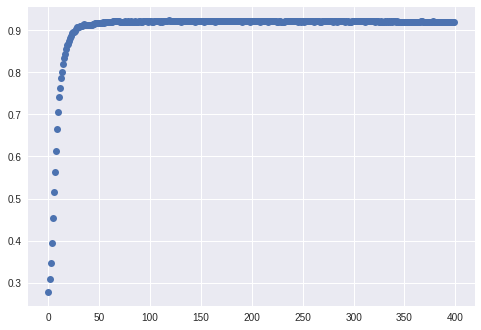

In [240]:
 plt.plot(acc[0]+acc[1],'o')

In [241]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arra

biases = weights[1]
weights = weights[0]
# w = np.vstack([biases,weights])
# print w.T 

In [242]:
weights.T

array([[ 1.37939751, -1.8167696 , -1.16025281, -1.55927348, -3.87818718],
       [-2.88918996, -0.74269396, -1.20073128,  2.81019855,  2.27259564],
       [ 1.44679677,  1.10221112,  3.07750177, -2.15545654, -1.11313546]], dtype=float32)

In [243]:
lr.coef_

array([[ 1.60178915, -1.30107314, -1.34847075, -1.42618212, -3.11060128],
       [-3.51320571, -0.21453131, -1.55648735,  3.69591732,  4.03644283],
       [ 1.64067447,  1.75247033,  3.09915196, -2.00621937, -0.2104194 ]])

In [244]:
biases

array([-1.10561919,  2.32619333, -1.97032893], dtype=float32)

In [245]:
lr.intercept_

array([-3.15658622,  1.02492416, -4.20219785])